In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Načítanie CSV súboru s dátami
df = pd.read_csv("toxic_sk_for_bert.csv")

# Odstránenie prázdnych riadkov
df = df.dropna() 

# Konverzia stĺpca 'label' na celé čísla
df['label'] = df['label'].astype(int)

In [18]:
# Rozdelenie dát na tréning a testovanie, 80 % pôjde na trénovanie, 20 % na test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42)

In [19]:
# Načítanie predtrénovaného anglického BERT tokenizeru ============ #
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizácia textov na číselné vstupy pre model 
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

In [20]:
# Vytvorenie trénovacích a testovacích TensorDatasetov
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels.tolist(), dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels.tolist(), dtype=torch.long)
)

In [21]:
# Načítanie predtrénovaného BERT modelu pre klasifikáciu 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#  Výber zariadenia (GPU/CPU) a presun modelu 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# Príprava DataLoaderov pre tréning a test 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  

In [24]:
# Inicializácia optimalizátora a funkcie straty 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
# Tréningový cyklus (10 epôch)
for epoch in range(10):
    model.train()  # nastavíme model do trénovacieho módu
    total_loss = 0  

    for batch in train_loader:
        optimizer.zero_grad()  # Odstránenie starých gradientov, aby sa neprekrývali s novými
        
        # Prenesieme dáta na GPU alebo CPU podľa konfigurácie
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Model vypočíta predikcie
        outputs = model(input_ids, attention_mask=attention_mask) 
      
        # Výpočet chyby
        loss = loss_fn(outputs.logits, labels)  
       
        #  výpočet gradientov podľa straty
        loss.backward()  

        # Aktualizácia váh
        optimizer.step() 

        # Strata k celkovej strate pre túto epochu
        total_loss += loss.item()
    
    # Priemerná strata na konci epóchy
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Priemerná strata: {avg_loss:.4f}")

Epoch 1, Priemerná strata: 0.6283
Epoch 2, Priemerná strata: 0.3583
Epoch 3, Priemerná strata: 0.2177
Epoch 4, Priemerná strata: 0.1374
Epoch 5, Priemerná strata: 0.0918
Epoch 6, Priemerná strata: 0.0682
Epoch 7, Priemerná strata: 0.0594
Epoch 8, Priemerná strata: 0.0401
Epoch 9, Priemerná strata: 0.0289
Epoch 10, Priemerná strata: 0.0336


In [26]:
# Prepnutie modelu do režimu vyhodnotenia
model.eval()  # nastavíme model do eval módu (žiadne aktualizácie)

# Premenné na uloženie predikcií a skutočných hodnôt pre neskoršie porovnanie
all_preds = []  # všetky predikcie
all_labels = []  # skutočné hodnoty

In [27]:
# Zobrazenie všetkých časti testovacích dát
for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy() # Získanie skutočných odpovedí (štítkov), ktoré model porovnáva so svojimi predikciami

    with torch.no_grad():  # nevypočítavame gradienty
        outputs = model(input_ids, attention_mask=attention_mask) # Model predpovedá výstupy pre dané vstupy
    
    # Výber triedy, ktorú model odhadol ako najpravdepodobnejšiu
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  

    # Uloženie predikcie a skutočných odpovedí na porovnanie
    all_preds.extend(preds)
    all_labels.extend(labels)


In [28]:
# Vypočítanie úspešnosťi modelu
accuracy = accuracy_score(all_labels, all_preds)
print("Úspešnosť modelu:", accuracy)

Úspešnosť modelu: 0.8790373654211526


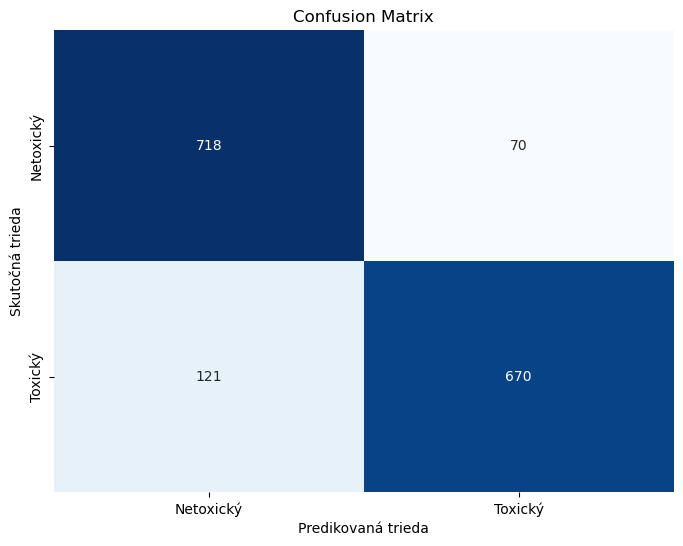

In [29]:
# Vytváranie matice zámen
cm = confusion_matrix(all_labels, all_preds)  

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Netoxický", "Toxický"],
            yticklabels=["Netoxický", "Toxický"])
plt.xlabel('Predikovaná trieda')
plt.ylabel('Skutočná trieda')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Výpočet falošnej negatívnej miery 
def false_negative_rate(fn, tp):
    return fn / (fn + tp) if (fn + tp) > 0 else 0.0

false_negatives = cm[1][0]  # predikoval netoxický, ale mal byť toxický
true_positives = cm[1][1]   # správne identifikovaný toxický komentár
fnr = false_negative_rate(false_negatives, true_positives)

print("False negatives:", false_negatives)
print("True positives:", true_positives)
print("False negative rate:", fnr)

False negatives: 121
True positives: 670
False negative rate: 0.1529709228824273
